##**Bengali Handwritten Digits Classification** (0 - 9) Using Nueral Network

## Logistic Regression

- Logistic regression is a learning algorithm used in a supervised learning
problem when the output are all either zero or one.
    
- The goal of logistic regression is to minimize the error between its
predictions and training data.
- Output: probability [0, 1] given input belonging to a class



**Logistic Regression Example: Positive vs Negative**

**Input:** Sequence of Words

**Output:** Probability of positive

- Input: "Delivery speed was good"
- Output: **p = 0.8**

- Input: "Terrible Customer Service"
- Output: **p = 0.2**

**NumtaDB: Bengali Handwritten Digits** is a dataset of Bengali Handwritten. The dataset contains Bangla handwritten digits (0 through 9), and all the images are manually labelled and saved in a CSV file. I use it to train our model to **Classify Bangla Handwritten Digits**.

**Dataset Link:** https://www.kaggle.com/BengaliAI/numta/

**Snapshot from NumtaDB**

<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '../content/gdrive/My Drive/Data/saved_model/'

Mounted at /content/gdrive


In [ ]:
# Installing Kaggle dependency
!pip install kaggle

Upload Kaggle API

In [ ]:
# Attaching kaggle Database
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulkhan93","key":"562b2611685fe1b70ec67f759d7c6622"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
 
# Change the permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading Dataset
!kaggle datasets download -d BengaliAI/numta

100% 1.91G/1.91G [00:19<00:00, 37.7MB/s]
100% 1.91G/1.91G [00:19<00:00, 105MB/s] 


Unzip Dataset

In [ ]:
from zipfile import ZipFile
filename = "numta.zip"
 
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("Done")

Done


- **Input dimension:**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [ ]:
# Hyperparameters
 
batch_size = 100
num_iters = 50000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10
 
learning_rate = 0.1
 
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Reading CSV file

In [ ]:
def readCSV(csv_filename):
  df = pd.read_csv(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = readCSV('training-a.csv')
c_csv = readCSV('training-c.csv')
d_csv = readCSV('training-d.csv')

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file.columns)   #First 5 Rows of the CSV File
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)
c_csv = dropColumns(c_csv)
d_csv = dropColumns(d_csv)

Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')
Index(['filename', 'digit'], dtype='object')


Train Test Splitting (Train : Test  90 : 10)

In [ ]:
# Merged all data
total_csv = [a_csv, c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))
 
# Train Test split
train, test = train_test_split(merged_csv, test_size=0.10, shuffle=True)
print(len(train))
print(len(test))

54908
49417
5491


Copy dataset into one folder

In [ ]:
def moveImages(folder_name):
  src = folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)

In [ ]:
TRAIN_PATH = "../content/train/"
os.mkdir('train')
moveImages('training-a')
print('A Done')
moveImages('training-c')
print('C Done')
moveImages('training-d')
print('D Done')

A Done
C Done
D Done


Implementing Dataset Interface

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

### Loading Custom Dataset

- **totaldata:** 54,908
- **minibatch:** 
  - Number of examples in **1** iteration

- **iterations:**
  - *1 iteration: one mini-batch forward & backward pass. That means a parameter (wights and biases) update.*

- **epochs**
  - 1 epoch: running through the whole dataset once
  - $epochs = iterations \div \frac{totaldata}{minibatch}$ 


In [ ]:
'''
LOADING DATASET
'''
train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
])

train_dataset  = Dataset(train, TRAIN_PATH, train_transform)
test_dataset = Dataset(test, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_dataset))

'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

Trainig Samples:  49417


In [ ]:
print(train_dataset[1])
print(train_dataset[0][0].size())
print(train_dataset[0][0].numpy().shape)
print(train_dataset[0][1])

(tensor([[[0.9529, 0.9529, 0.9569, 0.9608, 0.9569, 0.9608, 0.9608, 0.9569,
          0.9569, 0.9608, 0.9608, 0.9569, 0.9529, 0.9490, 0.9412, 0.9451,
          0.9490, 0.9490, 0.9490, 0.9490, 0.9490, 0.9529, 0.9529, 0.9529,
          0.9490, 0.9490, 0.9529, 0.9529],
         [0.9529, 0.9569, 0.9529, 0.9529, 0.9529, 0.9569, 0.9569, 0.9569,
          0.9608, 0.9608, 0.9608, 0.9569, 0.9569, 0.9529, 0.9490, 0.9490,
          0.9490, 0.9490, 0.9490, 0.9490, 0.9529, 0.9529, 0.9529, 0.9529,
          0.9529, 0.9529, 0.9569, 0.9529],
         [0.9529, 0.9569, 0.9569, 0.9529, 0.9529, 0.9569, 0.9569, 0.9569,
          0.9608, 0.9608, 0.9608, 0.9608, 0.9608, 0.9569, 0.9529, 0.9529,
          0.9490, 0.9529, 0.9529, 0.9569, 0.9569, 0.9529, 0.9529, 0.9529,
          0.9529, 0.9529, 0.9529, 0.9529],
         [0.9569, 0.9608, 0.9569, 0.9569, 0.9569, 0.9569, 0.9569, 0.9569,
          0.9608, 0.9569, 0.9569, 0.9569, 0.9569, 0.9569, 0.9569, 0.9569,
          0.9490, 0.9529, 0.9569, 0.9569, 0.9569, 0.9569

9


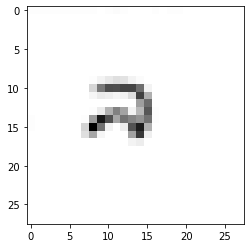

In [ ]:
## Displaying a Image from Dataset
import matplotlib.pyplot as plt 

print(train_dataset[40][1])
show_img = train_dataset[40][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

### Step #1 : Designing Deep Neural Model

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, 512)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer
        self.linear_2 = nn.Linear(512, 256)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer
        self.linear_3 = nn.Linear(256, 128)
        ### Non-linearity in 2nd hidden layer
        self.softmax_3 = nn.Softmax()

        self.linear_out = nn.Linear(128, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)

        ### 2nd hidden layer
        out = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.softmax_3(out)

        probas = self.linear_out(out)

        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)


DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=512, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=512, out_features=256, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=256, out_features=128, bias=True)
  (Lrelu_3): LeakyReLU(negative_slope=0.01)
  (linear_out): Linear(in_features=128, out_features=10, bias=True)
)

###Step #2 : Constructing loss and optimizer (select from PyTorch API)

We use Cross Entropy Loss to calculate our loss before we backpropagate and update our parameters.

`criterion = nn.CrossEntropyLoss() ` 

It does 2 things at the same time.

1. Computes softmax **([Logistic or Sigmoid]/softmax function)**
2. Computes Cross Entropy Loss

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# Create Directory
saveModel = path + 'i' + str(num_iters) +'_b' + str(batch_size) +'_L' + str(learning_rate)
check_dir = os.listdir(path)
if ('i' + str(num_iters) +'_b' + str(batch_size) +'_L' + str(learning_rate) not in check_dir):
  os.mkdir(saveModel)

# Save Model
def saveModel(batch,iteration,learningRate):
  save_model = True
  if save_model is True:
      # Saves only parameters
      # wights & biases
      torch.save(model.state_dict(), path + 'i' + str(num_iters) + '_b' + str(batch_size) +'_L' + str(learning_rate) + '/logistic_i' + str(iteration) +'_b' + str(batch_size) +'_L' + str(learning_rate) +'.pkl') 

##Step #3: Model Training

In [ ]:
iteration_loss = []
iter = 1

In [ ]:
'''
TRAIN THE MODEL
'''
loss_path = path + 'i'+ str(num_iters) + '_b' + str(batch_size) +'_L' + str(learning_rate) +'/accuracy_loss.txt'
f = open(loss_path, "a")
f.write("Iteration\tLoss\tAccuracy\n")
f.close()
 
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
        optimizer.step()
        
        print("\rIteration:{}".format(iter), end="")
        iter += 1
        if iter % 1000 == 0:
            saveModel(batch_size, iter,learning_rate)
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader: 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('\nIteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            f = open(loss_path, "a")
            f.write(str(iter) + "\t" + str(loss.item()) + "\t"+ str(accuracy) +"\n")
            f.close()

Iteration:499
Iteration: 500. Loss: 2.304914712905884. Accuracy: 10.344199599344382
Iteration:999
Iteration: 1000. Loss: 2.3006057739257812. Accuracy: 10.489892551447824
Iteration:1499
Iteration: 1500. Loss: 2.3009819984436035. Accuracy: 10.271353123292661
Iteration:1999
Iteration: 2000. Loss: 2.296576499938965. Accuracy: 9.051174649426335
Iteration:2499
Iteration: 2500. Loss: 2.297712564468384. Accuracy: 10.12566017118922
Iteration:2999
Iteration: 3000. Loss: 2.266228675842285. Accuracy: 10.344199599344382
Iteration:3499
Iteration: 3500. Loss: 2.2708346843719482. Accuracy: 11.218357311965034
Iteration:3999
Iteration: 4000. Loss: 2.2657546997070312. Accuracy: 14.387179020214898
Iteration:4499
Iteration: 4500. Loss: 2.225022077560425. Accuracy: 10.18029502822801
Iteration:4999
Iteration: 5000. Loss: 2.3514132499694824. Accuracy: 13.695137497723548
Iteration:5499
Iteration: 5500. Loss: 2.359041690826416. Accuracy: 12.930249499180476
Iteration:5999
Iteration: 6000. Loss: 2.156617403030395

KeyboardInterrupt: ignored

### Load Model and iteration Loss

In [ ]:
root_path = '/content/gdrive/My Drive/Data/saved_model/i100000_b200_L0.1_Layer_3_784->500->250->166->10 75%/'

# read train.txt file line by line
with open(root_path + 'accuracy_loss.txt', "r") as loss:
    FileasList = loss.readlines()

acc_loss = []
iteration_loss = []
for i in range(len(FileasList)):
  if (i == 0):
    continue
  acc_loss.append(FileasList[i].split())
  iteration_loss.append(float(acc_loss[i-1][1]))


load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'logistic_i67000_b200_L0.1.pkl'))

[2.306617259979248, 2.325493097305298, 2.251410722732544, 2.2646965980529785, 2.2479844093322754, 2.2689883708953857, 2.2995901107788086, 2.2577004432678223, 2.238097906112671, 2.1877567768096924, 2.2747621536254883, 2.1678991317749023, 2.2208003997802734, 2.2837026119232178, 2.228369951248169, 2.331925868988037, 2.2205376625061035, 2.214029312133789, 2.2939884662628174, 2.2534687519073486, 2.265758752822876, 2.218312978744507, 2.321096181869507, 2.1469390392303467, 2.046705722808838, 2.046894073486328, 2.1665453910827637, 2.0613160133361816, 2.0198702812194824, 2.0058274269104004, 2.124997615814209, 2.0854015350341797, 2.0770363807678223, 2.0727808475494385, 2.1141583919525146, 2.2110936641693115, 2.1382083892822266, 2.1026570796966553, 2.177232027053833, 2.1081511974334717, 2.004509925842285, 2.244546890258789, 2.121522903442383, 1.9599860906600952, 2.173239231109619, 1.96543288230896, 2.0720200538635254, 2.037410020828247, 2.0109922885894775, 2.194748640060425, 1.9265892505645752, 1

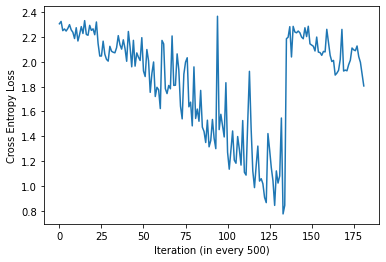

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

### Testing Loaded Model with Digits

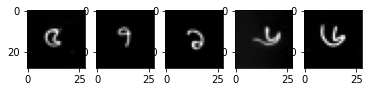

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [5 7 1 6 6]


**Different Settings**

<table>
<thead>
  <tr>
    <th class="tg-0pky" colspan="1"></th>
    <th class="tg-0pky" colspan="1">Setting 1</th>
    <th class="tg-0pky" colspan="1">Setting 2</th>
    <th class="tg-0lax" colspan="1">Setting 3</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><b>Iteration</b></td>
    <td class="tg-0pky"><center>50000</center></td>
    <td class="tg-0pky"><center> 100000</center></td>
    <td class="tg-0pky"><center>50000 </center></td>
    
  </tr>
  <tr>
    <td class="tg-0pky"><b>Batch Size</b></td>
    <td class="tg-0pky"><center>150 </center></td>
    <td class="tg-0pky"><center>200 </center></td>
    <td class="tg-0pky"><center> 100</center></td>
  </tr>
  <tr>
    <td class="tg-0pky"><b>Learning Rate</b></td>
    <td class="tg-0pky"><center>0.1 </center></td>
    <td class="tg-0pky"><center> 0.1</center></td>
    <td class="tg-0pky"><center>0.01 </center></td>
  </tr>
  <tr>
    <td class="tg-0pky"><b>Hidden Layer</b></td>
    <td class="tg-0pky"><center> 4</center></td>
    <td class="tg-0pky"><center>3 </center></td>
    <td class="tg-0pky"><center> 3</center></td>
  </tr>
  <tr>
    <td class="tg-0pky"><b>Activatin Function</b></td>
    <td class="tg-0pky"><center> nn.ReLU</center></td>
    <td class="tg-0pky"><center> nn.ReLU</center></td>
    <td class="tg-0pky"><center>nn.ReLU<br>nn.Softmax </center></td>
  </tr>
  <tr>
    <td class="tg-0pky"><b>Nodes in Layer</b></td>
    <td class="tg-0pky"><center>784 -> 500<br>500 -> 250<br>250 -> 166</br>166 -> 125<br>125 -> 10 </center></td>
    <td class="tg-0pky"><center> 784 -> 500<br>500 -> 250<br>250 -> 166</br>166 -> 10  </center></td>
    <td class="tg-0pky"><center>784 -> 100<br>100 -> 100<br>100 -> 100</br>100 -> 10   </center></td>
  </tr>

</tbody>

</table>

**Result:**
<table>
<thead>
  <tr>
    <th class="tg-0pky" colspan="2">Setting 1</th>
    <th class="tg-0pky" colspan="2">Setting 2</th>
    <th class="tg-0lax" colspan="2">Setting 3</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky"><b>iteration</b></td>
    <td class="tg-0pky"><b>accuracy</b></td>
    <td class="tg-0pky"><b>iteration</b><br></td>
    <td class="tg-0pky"><b>accuracy</b></td>
    <td class="tg-0lax"><b>iteration</b></td>
    <td class="tg-0lax"><b>accuracy</b></td>
  </tr>
  <tr>
    <td class="tg-0pky">1000</td>
    <td class="tg-0pky">10.54</td>
    <td class="tg-0pky">1000</td>
    <td class="tg-0pky">17.75</td>
    <td class="tg-0lax">1000</td>
    <td class="tg-0lax">9.65</td>
  </tr>
  <tr>
    <td class="tg-0pky">3000</td>
    <td class="tg-0pky">22.67</td>
    <td class="tg-0pky">3000</td>
    <td class="tg-0pky">21.67</td>
    <td class="tg-0lax">3000</td>
    <td class="tg-0lax">10.90</td>
  </tr>
  <tr>
    <td class="tg-0pky">6000</td>
    <td class="tg-0pky">21.39</td>
    <td class="tg-0pky">8000</td>
    <td class="tg-0pky">17.70</td>
    <td class="tg-0lax">5000</td>
    <td class="tg-0lax">21.38</td>
  </tr>
  <tr>
    <td class="tg-0pky">7500</td>
    <td class="tg-0pky">24.73</td>
    <td class="tg-0pky">12500</td>
    <td class="tg-0pky">25.76</td>
    <td class="tg-0lax">7000</td>
    <td class="tg-0lax">18.46</td>
  </tr>
  <tr>
    <td class="tg-0pky">9500</td>
    <td class="tg-0pky">28.13</td>
    <td class="tg-0pky">22000</td>
    <td class="tg-0pky">29.22</td>
    <td class="tg-0lax">9500</td>
    <td class="tg-0lax">25.95</td>
  </tr>
  <tr>
    <td class="tg-0pky">12000</td>
    <td class="tg-0pky">30.61</td>
    <td class="tg-0pky">30000</td>
    <td class="tg-0pky">36.95</td>
    <td class="tg-0lax">11500</td>
    <td class="tg-0lax">15.57</td>
  </tr>
  <tr>
    <td class="tg-0pky">13500</td>
    <td class="tg-0pky">32.45</td>
    <td class="tg-0pky">33500</td>
    <td class="tg-0pky">43.01</td>
    <td class="tg-0lax">12500</td>
    <td class="tg-0lax">33.09</td>
  </tr>
  <tr>
    <td class="tg-0pky">17000</td>
    <td class="tg-0pky">19.37</td>
    <td class="tg-0pky">37000</td>
    <td class="tg-0pky">44.83</td>
    <td class="tg-0lax">15000</td>
    <td class="tg-0lax">27.39</td>
  </tr>
  <tr>
    <td class="tg-0pky">25000</td>
    <td class="tg-0pky">41.99</td>
    <td class="tg-0pky">41000</td>
    <td class="tg-0pky">48.53</td>
    <td class="tg-0lax">17000</td>
    <td class="tg-0lax">30.23</td>
  </tr>
  <tr>
    <td class="tg-0pky">29000</td>
    <td class="tg-0pky">42.32</td>
    <td class="tg-0pky">61500</td>
    <td class="tg-0pky">66.94</td>
    <td class="tg-0lax">18500</td>
    <td class="tg-0lax">15.86</td>
  </tr>
  <tr>
    <td class="tg-0pky">30000</td>
    <td class="tg-0pky">49.06</td>
    <td class="tg-0pky">67000</td>
    <td class="tg-0pky"><b>75.54</b></td>
    <td class="tg-0lax">20000</td>
    <td class="tg-0lax">38.49</td>
  </tr>
  <tr>
    <td class="tg-0pky">35000</td>
    <td class="tg-0pky">37.20</td>
    <td class="tg-0pky">69000</td>
    <td class="tg-0pky">14.24</td>
    <td class="tg-0lax">22000</td>
    <td class="tg-0lax">20.96</td>
  </tr>
  <tr>
    <td class="tg-0pky">40000</td>
    <td class="tg-0pky">62.64</td>
    <td class="tg-0pky">72000</td>
    <td class="tg-0pky">15.33</td>
    <td class="tg-0lax">24000</td>
    <td class="tg-0lax">30.34</td>
  </tr>
  <tr>
    <td class="tg-0pky">42000</td>
    <td class="tg-0pky"><b>68.13</b></td>
    <td class="tg-0pky">76000</td>
    <td class="tg-0pky">26.13</td>
    <td class="tg-0lax">34000</td>
    <td class="tg-0lax">43.30</td>
  </tr>
  <tr>
    <td class="tg-0pky">44000</td>
    <td class="tg-0pky">51.50</td>
    <td class="tg-0pky">80000</td>
    <td class="tg-0pky">16.68</td>
    <td class="tg-0lax">38000</td>
    <td class="tg-0lax"><b>52.59</b></td>
  </tr>
  <tr>
    <td class="tg-0pky">47000</td>
    <td class="tg-0pky">37.62</td>
    <td class="tg-0pky">85000</td>
    <td class="tg-0pky">32.27</td>
    <td class="tg-0lax">39000</td>
    <td class="tg-0lax">49.71</td>
  </tr>
  <tr>
    <td class="tg-0pky">49000</td>
    <td class="tg-0pky">39.37</td>
    <td class="tg-0pky">90000</td>
    <td class="tg-0pky">30.04</td>
    <td class="tg-0lax">40500</td>
    <td class="tg-0lax">35.23</td>
  </tr>
  

</tbody>
</table>

**Result Analysis:** I trained our model using different hyperperameters to determine the best hyperperameter to train our model. Setting 2 gives us more accuracy among them. Highest accuracy of our Model is **75.54%** at 23000 no iteration.